<a href="https://colab.research.google.com/github/ordepzero/generative_ai/blob/main/Advanced_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [20]:
def show(tensor, num=25, wandb=0, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)

  # optional
  if(wandb == 1 and wandbact == 1):
    wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})

  plt.imshow(grid.clip(0,1))
  plt.show()

In [37]:
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device = 'cuda' # GPU

cur_step = 0
crit_cycles = 5
gen_losses = [] # acumulate the loss values of generator
crit_losses = [] # acumulate the loss values of crict
show_step = 35 # how many step we wanna show
save_step = 35 # how many step we wanna save a checkpoint with the values of the parameters of the generator and the critc

# saving the parameters we can start/stop anytime

wandbact = 1 # yes, we want to track stats through weights and bias (optional)

In [22]:
!pip install wandb -qqq

import wandb
wandb.login(key='6422d87cbfee9e421b937fa0782a7fe3a333f565') # load from site

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [23]:
%%capture

experiment_name = wandb.util.generate_id()

myrun = wandb.init(
    project = 'wang',
    group = experiment_name,
    config = {
        'optimizer': 'sgd',
        'model': 'wang gp',
        'epoch': '1000',
        'batch_size': 128
    }
)

config = wandb.config

In [24]:
print(experiment_name)

3eogkecd


In [25]:
# Generator Model

class Generator(nn.Module):
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(
        # ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
        # Calculatin new width and height: (n-1) * stride - 2 * passing + ks
        # n = width or height
        # ks = kernel size
        # we begin with 1x1 image with z_dim number of channels (200)
        nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), # 4x4 (ch: 200 -> 512)
        nn.BatchNorm2d(d_dim * 32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 32, d_dim * 16, 4, 2, 1), # 8x8 (ch 512 -> 256)
        nn.BatchNorm2d(d_dim * 16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 16, d_dim * 8, 4, 2, 1), # 16x16 (ch 256 -> 128)
        nn.BatchNorm2d(d_dim * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 8, d_dim * 4, 4, 2, 1), # 16x16 (ch 128 -> 64)
        nn.BatchNorm2d(d_dim * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 4, d_dim * 2, 4, 2, 1), # 64x64 (ch 64 -> 32)
        nn.BatchNorm2d(d_dim * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 2, 3, 4, 2, 1), # 128x128 (ch 32 -> 3)
        nn.Tanh() # produce result in the range from -1 to 1
    )


  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1) # 128 x 200 x 1 x 1
    return self.gen(x)

def gen_noise(num, z_dim, device='cuda'):
  return torch.randn(num, z_dim, device=device) # 128 x 200

In [26]:
# The Critc isn't limited to be between 0 and 1, like discriminator, it can be any value

class Critic(nn.Module):

  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
        # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
        # New width and height: (n + 2 * pad - ks)//stride + 1
        nn.Conv2d(3, d_dim, 4, 2, 1), # (n + 2 * pad - ks)// stride + 1 = (128 + 2 * 1 - 4)//2 + 1 = 64x64 (ch: 3, 16)
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim, d_dim * 2, 4, 2, 1), # 32x32 (ch: 16 -> 32)
        nn.InstanceNorm2d(d_dim * 2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 2, d_dim * 4, 4, 2, 1), # 16x16 (ch: 32 -> 64)
        nn.InstanceNorm2d(d_dim * 4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 4, d_dim * 8, 4, 2, 1), # 8x8 (ch: 64 -> 128)
        nn.InstanceNorm2d(d_dim * 8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 8, d_dim * 16, 4, 2, 1), # 4x4 (ch: 128 -> 256)
        nn.InstanceNorm2d(d_dim * 16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 16, 1, 4, 1, 0) #(n+2*pad-ks)//stride+1 => (4+2*0-4)//1+1 = 1x1 (ch: 256 -> 1)
    )

  def forward(self, image):
    #image: 128 x 3 x 128 x 128
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1

    return crit_pred.view(len(crit_pred),-1) # 128 x 1

In [27]:
## optional, init your weihts in different ways

def init_weights(m):

  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConcTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.2)
    torch.nn.init.constante_(m.bias, 0)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.2)
    torch.nn.init.constante_(m.bias, 0)


In [28]:
# load dataset

import gdown, zipfile
url='https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a'

path = 'data/celeba'
download_path = f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

gdown.download(url, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(path)

Downloading...
From: https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:13<00:00, 106MB/s]


In [29]:
### Dataset, Dataloader, declare gen, crit, test dataset

class Dataset(Dataset):

  def __init__(self, path, size=128, lim=10000):
    '''
    size: heigth and width of image
    lim: quantity of images
    '''
    self.sizes = [size, size]
    items, labels = [], []

    for data in os.listdir(path)[:lim]:
      # path: './data/celeba/img_align_celeba'
      # data: '114568.jpg'
      item = os.path.join(path, data)
      items.append(item)
      labels.append(data)

    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # (178, 128)
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False) # 3 x 128 x 128 $ from 0 to 255
    data = torch.from_numpy(data).div(255) # from 0 to 1
    return data, self.labels[idx]



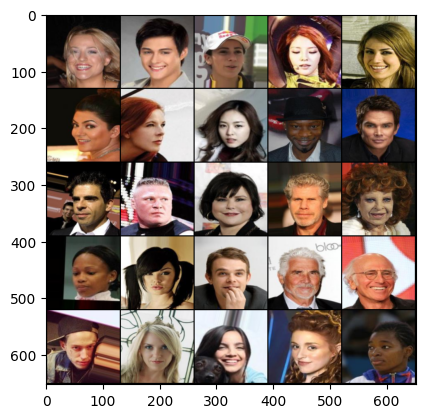

In [30]:
## Dataset

data_path = './data/celeba/img_align_celeba'
ds = Dataset(data_path, size=128, lim=10000)

dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

# Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# OPtimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

# Initializations
# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

# wandb optional
if wandbact==1:
  wandb.watch(gen, log_freq=100)
  wandb.watch(crit, log_freq=100)


x, y = next(iter(dataloader))
show(x) # show "real" images of the CelebA dataset that will be used later by the Critic network

In [31]:
# Gradient Penalty calculation

def get_gp(real, fake, crit, alpha, gamma=10):
  '''
  gradiente penalty: interpolation between real and fake images
  gamma: regularization intesity
  '''
  mix_images = real * alpha + fake * (1 - alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # predictions of crit: 128 x 1

  # compute and return the sum of gradients of the outputs with respect to the inputs
  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph = True,
      create_graph = True,
  )[0] # 128 x 3 x 128 x 128 (result of that final [0] selection)


  gradient = gradient.view(len(gradient), -1)  # 128 x 49152

  # The norm of a vector is a positive number that expresses its magnitude.
  # It can be calculated in different ways. Thas's why you have different types of norm (L1, L2, etc)
  gradient_norm = gradient.norm(2, dim=1)

  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

In [32]:
## Save and load chackpoints

root_path = './data/'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  }, f'{root_path}G-{name}.pkl')

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f'{root_path}C-{name}.pkl')

  print('Save checkpoint')

def load_checkpoint(name):
  checkpoint = torch.load(f'{root_path}G-{name}.pkl')
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f'{root_path}C-{name}.pkl')
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")

In [33]:
#epoch = 1
#save_checkpoint("teste")

Save checkpoint


In [34]:
#epoch = 1
#load_checkpoint("teste")

Loaded checkpoint


In [36]:
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs = len(real) # 128
    real = real.to(device)

    ### Critic
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad() #

      noise = gen_noise(cur_bs, z_dim)
      fake = gen(noise)

      # Critic predict the real and fake images
      crit_fake_pred = crit(fake.detach()) # avoid the generator gradients, the crit uses your own weights
      crit_real_pred = crit(real)

      alpha = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True) # 128 x 1 x 1 x 1
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss += crit_loss.item() / crit_cycles

      crit_loss.backward(retain_graph=True) # calcula the gradient of the weigths related do loss
      crit_opt.step() # adjust the weigths of crit based on gradients calculated during backpropagation (backward)

    crit_losses + [mean_crit_loss]

    ### Generator
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses += [gen_loss.item()]

  0%|          | 0/79 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


NameError: name 'gen_losses' is not defined